In [1]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob
import gsw
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os


In [2]:
path_files_soda_raw = '/glade/work/jhayron/Data4Predictability/SODA/'

In [3]:
files = np.sort(glob.glob(path_files_soda_raw+'*.nc'))

In [4]:
def cut_and_select(ds, var_name, lat_range, lon_range):
    """
    Cut a rectangular region defined by latitude and longitude ranges from a dataset, and
    select one variable of interest.

    Parameters
    ----------
    ds : xarray.Dataset
        The input dataset containing the variable of interest and the latitude and longitude
        coordinates.
    var_name : str
        The name of the variable to select.
    lat_range : tuple of two floats
        The latitude range to cut, defined as (min_lat, max_lat).
    lon_range : tuple of two floats
        The longitude range to cut, defined as (min_lon, max_lon).

    Returns
    -------
    xarray.Dataset
        A new dataset containing only the selected variable, with the corresponding latitude
        and longitude coordinates.
    """
    # Select the variable of interest
    var = ds[var_name]

    # Cut the rectangular region based on the latitude and longitude ranges
    var_cut = var.sel(yt_ocean=slice(lat_range[0], lat_range[1]), xt_ocean=slice(lon_range[0], lon_range[1]))

    # Create a new dataset with only the selected variable and its coordinates
    ds_var = xr.Dataset({var_name: var_cut})

    return ds_var

def compute_ocean_heat_content(ds, depth):
    """
    Compute the ocean heat content of the top `depth` meters of the ocean for each horizontal grid cell
    from an ocean reanalysis dataset that contains potential temperature, potential density,
    and salinity.

    Parameters
    ----------
    ds : xarray.Dataset
        The input dataset containing the variables 'temp', 'prho', 'salt', 'yt_ocean', 'xt_ocean',
        and 'st_ocean'. These variables represent potential temperature (in degrees Celsius), potential
        density (in kg/m^3), salinity (in practical salinity units), latitude (in degrees North),
        longitude (in degrees East), and depth (in meters), respectively.
    depth : float
        The depth in meters of the ocean heat content to compute.

    Returns
    -------
    xarray.Dataset
        A new dataset containing only the variable 'ocean_heat_content', which represents the
        ocean heat content of the top `depth` meters of the ocean for each horizontal grid cell. The
        dataset also includes the corresponding latitude and longitude coordinates.
        The units of the ocean heat content are Joules per square meter (J/m^2).

    """
    
    # Compute the thickness of each depth layer
    ocean_depth = ds['st_ocean']  # units: m
    dz = np.diff(ocean_depth, axis=0)  # assume constant thickness for simplicity
    dz = np.append(dz, dz[-1])  # repeat last layer to match number of layers in rho_prime and Cp
    
    # Extract potential density and salinity
    sigma = ds['prho']  # units: kg/m^3
    salt = ds['salt']  # units: psu
    
    # Convert potential temperature to Kelvin
    theta = ds['temp']  # units: C
    # Convert potential temperature to Kelvin
    CT = gsw.CT_from_pt(salt,theta) #units: C
    # Get pressure from depth
    sea_pressure = gsw.p_from_z(-ocean_depth, ds['yt_ocean']) # units: db
    sea_pressure = np.repeat(sea_pressure.data[:,:,np.newaxis], 720,axis=2)
    # Temperature
    T = gsw.t_from_CT(salt, CT, sea_pressure) # units: degC
    
    # Compute the specific heat capacity of seawater
    Cp = gsw.cp_t_exact(salt, T, sea_pressure) #units: J/(kg*K)
    
    # Convert T to Kelvin
    T= T+273.15
    
    # Compute the ocean heat content
    depth_mask = ocean_depth <= depth  # select depths up to `depth`
    ohc = (sigma[:, depth_mask, :] * Cp[:, depth_mask, :] * dz[None, depth_mask, None, None] * T[:, depth_mask, :]).sum(dim='st_ocean')  # units: J/m^2
    
    # Create a new dataset with only the ocean heat content and the corresponding coordinates
    coords = {'latitude': ds['yt_ocean'], 'longitude': ds['xt_ocean']}
    ds_ohc = xr.Dataset({'ocean_heat_content': ohc}, coords=coords)
    ds_ohc.ocean_heat_content.attrs['units'] = 'J/m^2'
    
    return ds_ohc

def plot_ocean_heat_content(ds,depth):
    # Extract the ocean heat content and the coordinates
    ohc = ds['ocean_heat_content']
    lat = ds['latitude']
    lon = ds['longitude']

    # Create a map projection
    projection = ccrs.PlateCarree()

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': projection})

    # Plot the ocean heat content as a color mesh
    mesh = ax.pcolormesh(lon, lat, ohc[0], cmap='jet', transform=projection, vmin = ohc[0].quantile(0.1), vmax = ohc[0].quantile(0.95))#,vmax=4e+11, vmin= 3.614e+11)

    # Add a colorbar
    cbar = fig.colorbar(mesh, ax=ax, shrink=0.8)
    cbar.set_label('Ocean Heat Content (kJ/cm^2)')

    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Set the title
    ax.set_title(f'Ocean Heat Content (0-{depth}m)')

    # Show the plot
    plt.show()
    
def plot_map(ds, varname, longname='', cmap='YlOrRd', cbar_label=None):
    """
    Plots a global map of a given variable in the dataset.

    Parameters
    ----------
    ds : xarray.Dataset
        The input dataset containing the variable to be plotted.
    varname : str
        The name of the variable to be plotted.
    cmap : str or Colormap, optional
        The colormap to use in the plot. Defaults to 'YlOrRd'.
    cbar_label : str, optional
        The label to use for the colorbar. If not provided, the units of the variable in the dataset
        will be used.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting figure object.

    """
    # Extract data
    var = ds[varname]
    lat = ds['yt_ocean']
    lon = ds['xt_ocean']

    # Set up the projection and plot the data
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    p = ax.pcolormesh(lon, lat, var[0], cmap=cmap, transform=ccrs.PlateCarree(),vmin = var.quantile(0.1),vmax = var.quantile(0.98))

    # Set up the colorbar
    if cbar_label is None:
        cbar_label = f"({var.units})"
    cbar = plt.colorbar(p, ax=ax, orientation='horizontal', shrink=0.5, pad=0.1)
    cbar.ax.set_xlabel(cbar_label)
    
    
    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    
    # Set the title
    ax.set_title(f"{longname}")
    plt.show()
    # return fig


In [5]:
path_outputs = '/glade/u/home/jhayron/TemporalDataWR/SODA/'

In [6]:
len(files)

2068

In [ ]:
for i in range(len(files)):
    print(files[i])
    ds = xr.open_dataset(files[i])
    lat_range = (-30,90)
    lon_range = (0,360)

    # Compute the ocean heat content
    for depth in [50, 100, 200, 300, 700]:
        ohc = compute_ocean_heat_content(ds,depth)
        ohc = cut_and_select(ohc, 'ocean_heat_content', lat_range, lon_range)
        if os.path.exists(path_outputs+f'OHC{depth}/') == False:
            os.mkdir(path_outputs+f'OHC{depth}/')

        output_path =  path_outputs+f'OHC{depth}/'+files[i].split('/')[-1].replace('soda3.15.2_5dy_ocean_reg',f'OHC{depth}')
        ohc.to_netcdf(output_path)

    if os.path.exists(path_outputs+f'SST/') == False:
        os.mkdir(path_outputs+f'SST/')

    sst = cut_and_select(ds, 'temp', lat_range, lon_range).isel(st_ocean=0)
    output_path =  path_outputs+f'SST/'+files[i].split('/')[-1].replace('soda3.15.2_5dy_ocean_reg',f'SST')
    sst.to_netcdf(output_path)

    if os.path.exists(path_outputs+f'MLD/') == False:
        os.mkdir(path_outputs+f'MLD/')

    mld = cut_and_select(ds, 'mlt', lat_range, lon_range)
    output_path =  path_outputs+f'MLD/'+files[i].split('/')[-1].replace('soda3.15.2_5dy_ocean_reg',f'MLD')
    mld.to_netcdf(output_path)

    if os.path.exists(path_outputs+f'SSH/') == False:
        os.mkdir(path_outputs+f'SSH/')

    ssh = cut_and_select(ds, 'ssh', lat_range, lon_range)
    output_path =  path_outputs+f'SSH/'+files[i].split('/')[-1].replace('soda3.15.2_5dy_ocean_reg',f'SSH')
    ssh.to_netcdf(output_path)


/glade/work/jhayron/Data4Predictability/SODA/soda3.15.2_5dy_ocean_reg_1980_01_03.nc
/glade/work/jhayron/Data4Predictability/SODA/soda3.15.2_5dy_ocean_reg_1980_01_08.nc
/glade/work/jhayron/Data4Predictability/SODA/soda3.15.2_5dy_ocean_reg_1980_01_13.nc
/glade/work/jhayron/Data4Predictability/SODA/soda3.15.2_5dy_ocean_reg_1980_01_18.nc
/glade/work/jhayron/Data4Predictability/SODA/soda3.15.2_5dy_ocean_reg_1980_01_23.nc
/glade/work/jhayron/Data4Predictability/SODA/soda3.15.2_5dy_ocean_reg_1980_01_28.nc
/glade/work/jhayron/Data4Predictability/SODA/soda3.15.2_5dy_ocean_reg_1980_02_02.nc
/glade/work/jhayron/Data4Predictability/SODA/soda3.15.2_5dy_ocean_reg_1980_02_07.nc
/glade/work/jhayron/Data4Predictability/SODA/soda3.15.2_5dy_ocean_reg_1980_02_12.nc
/glade/work/jhayron/Data4Predictability/SODA/soda3.15.2_5dy_ocean_reg_1980_02_17.nc
/glade/work/jhayron/Data4Predictability/SODA/soda3.15.2_5dy_ocean_reg_1980_02_22.nc
/glade/work/jhayron/Data4Predictability/SODA/soda3.15.2_5dy_ocean_reg_1980_0

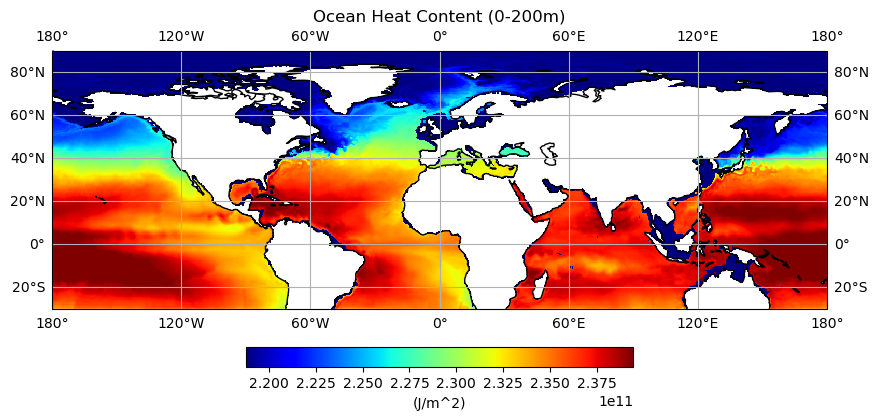

In [158]:
ohc['ocean_heat_content'].data[ohc['ocean_heat_content'].data==0] = np.nan
plot_map(ohc, f'ocean_heat_content', f'Ocean Heat Content (0-{depth}m)', cmap='jet')

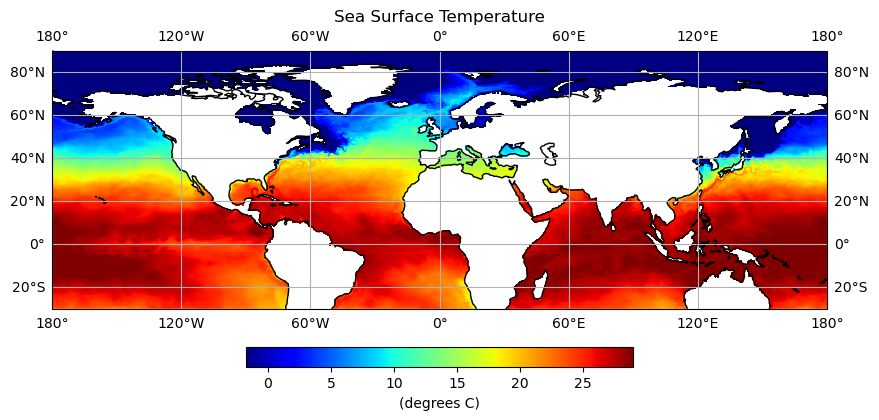

In [159]:
plot_map(sst, 'temp', 'Sea Surface Temperature', cmap='jet')

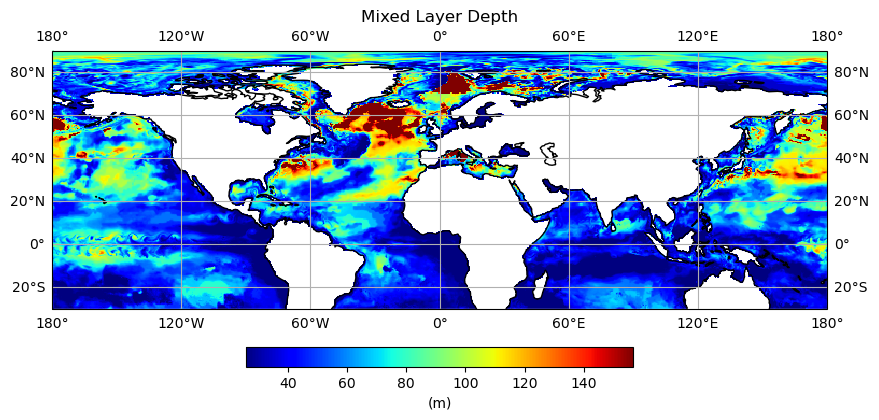

In [173]:
plot_map(mld, 'mlt', 'Mixed Layer Depth', cmap='jet')

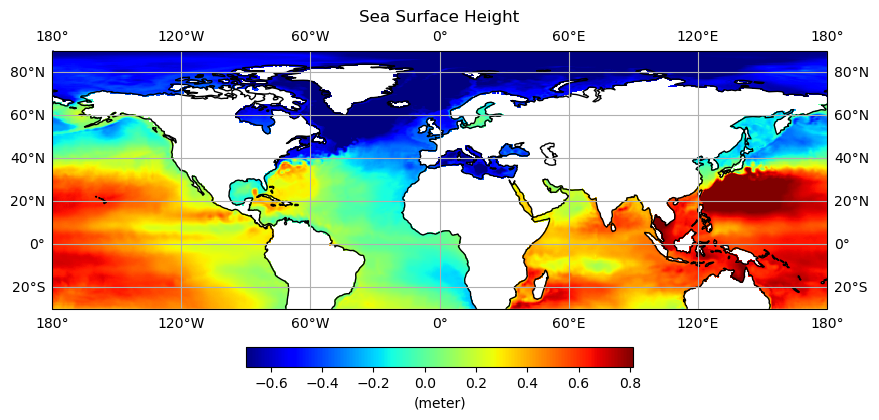

In [176]:
plot_map(ssh, 'ssh', 'Sea Surface Height', cmap='jet')